# Climate factors affecting wild fire analysis 
### using Machine learning Scikit-learn

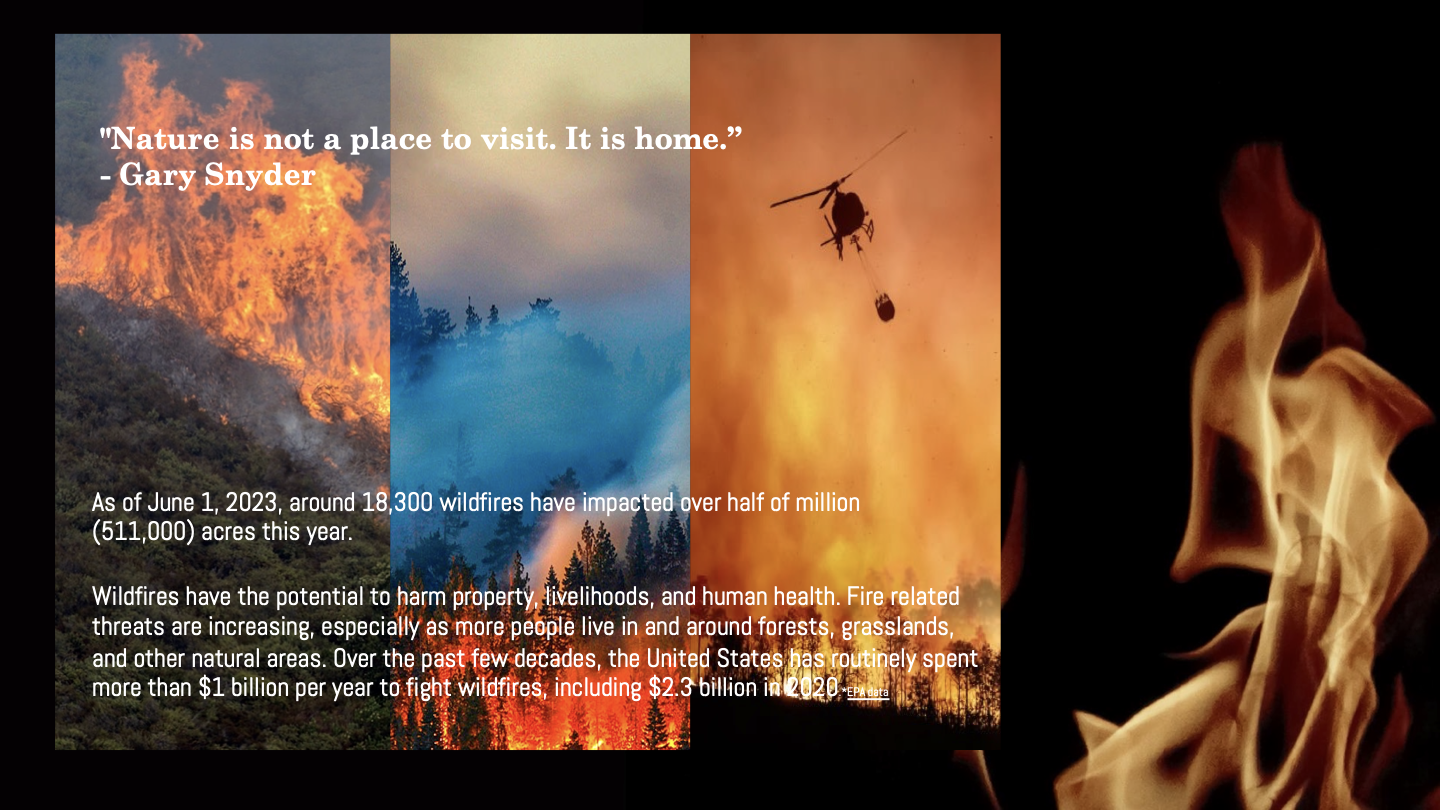

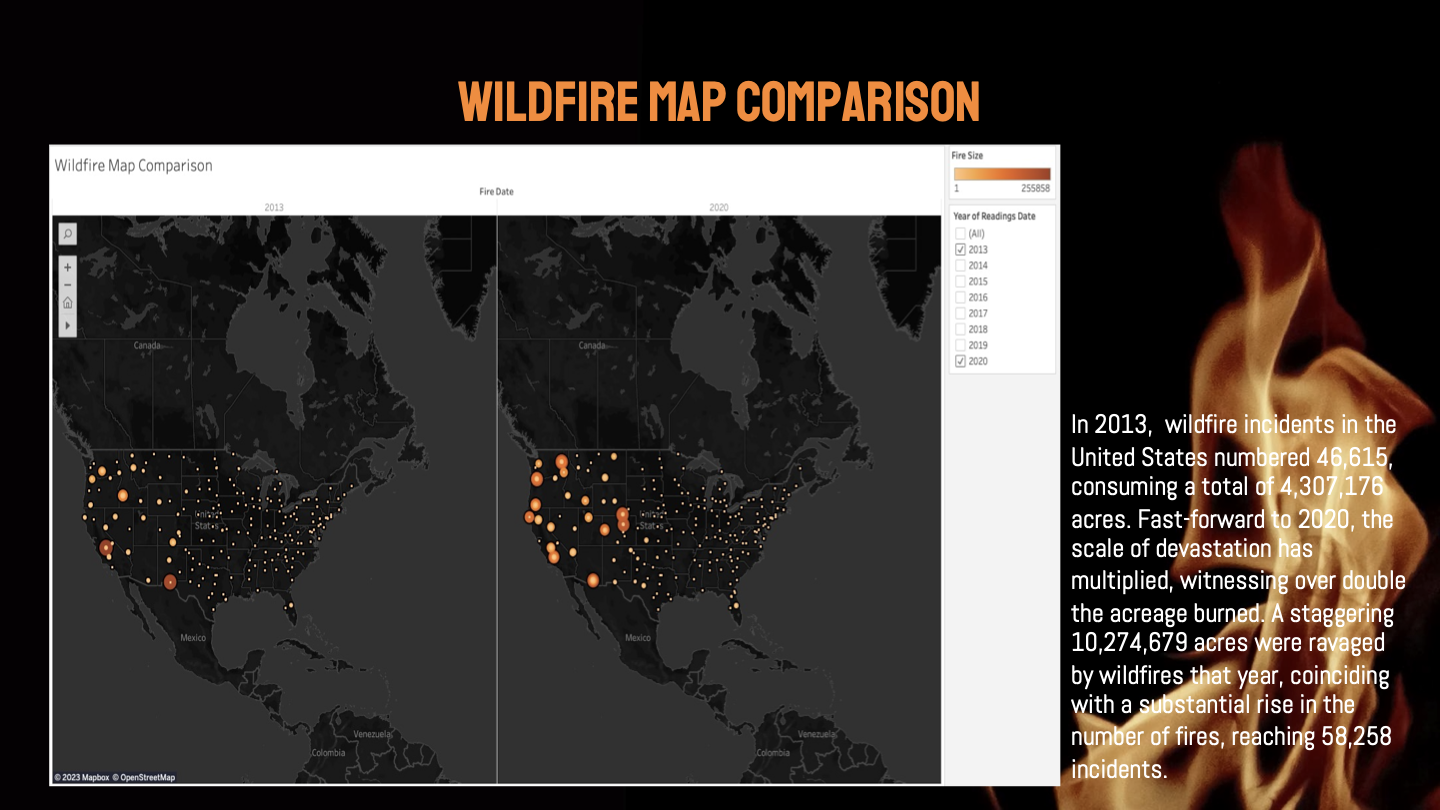 <br>

https://public.tableau.com/app/profile/celina.espinosa/viz/Wildfire_Prediction/WildfireMapComparison#1

##### **-- Data Prerequisite--** 
* Downloadd the wildfire sqllite data(data.sqlite) from kaggle https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition and place it under Resources folder 
* Download the climate data from NOAA(https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/) 
* Using the reusable merge_climate_wildfire_data.ipynb(juypter sourcefile) merge both climate and wild fire data for the years 2013 to 2020 and created the "final_data.csv" used for wildfire prediction based on climate factor
* Coverted to SQlite - Using csv_to_sqlite.ipynb(juypter sourcefile) convert the final_data.csv to "merge_climate_wildfire_data.sqlite"


##### **--Import Dependencies--**

In [2]:
# Import required modules and packages 
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# required packages for random forest analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Import required dependencies for neural network analysis
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [99]:
# Ref https://docs.python.org/3/library/sqlite3.html'
# place the downloaded data.sqlite from kaggle under resources folder

# read the file path
input_filename = "Resources/data.sqlite"

# define the year for which data should be pulled
year_greaterthan = 2012

#create a sql connection to the sqlite
conn = sqlite3.connect(input_filename)

#crete a query string to extract the data from sqlite
query = '''
    SELECT * FROM Fires
    WHERE FIRE_YEAR > :year;
'''

# run the query and stored the data int to a dataframe
us_wild_fire_df = pd.read_sql_query(query, conn, params={"year": year_greaterthan})

# display the dataframe info
us_wild_fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596140 entries, 0 to 596139
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   OBJECTID                       596140 non-null  int64  
 1   Shape                          596140 non-null  object 
 2   FOD_ID                         596140 non-null  int64  
 3   FPA_ID                         596140 non-null  object 
 4   SOURCE_SYSTEM_TYPE             596140 non-null  object 
 5   SOURCE_SYSTEM                  596140 non-null  object 
 6   NWCG_REPORTING_AGENCY          596140 non-null  object 
 7   NWCG_REPORTING_UNIT_ID         596140 non-null  object 
 8   NWCG_REPORTING_UNIT_NAME       596140 non-null  object 
 9   SOURCE_REPORTING_UNIT          596140 non-null  object 
 10  SOURCE_REPORTING_UNIT_NAME     596140 non-null  object 
 11  LOCAL_FIRE_REPORT_ID           596140 non-null  object 
 12  LOCAL_INCIDENT_ID             

## Analyzing Wildfire trend for the years 2013 to 2020 

In [100]:
#### Defining Wildfire dataframe
# Cleaning up the dataframe
# Using the data frame info, 
# Retain only required columns=['FOD_ID','SOURCE_SYSTEM_TYPE','FIRE_NAME''FIRE_YEAR','DISCOVERY_DATE',
#                                 'NWCG_CAUSE_CLASSIFICATION','NWCG_GENERAL_CAUSE', 'CONT_DATE',
#                                 'FIRE_SIZE','FIRE_SIZE_CLASS','LATITUDE','LONGITUDE','STATE'])
# Drop the unwanted columns based on column index.

us_wild_fire_df = us_wild_fire_df.drop(us_wild_fire_df.columns[[0,1,3,5,6,7,8,9,10,11,12,13,
                                                15,16,17,18,19,22,23,26,28,29,34,36,37,38 ]],axis = 1)

# Drop null value rows 
us_wild_fire_df.dropna(inplace=True)

# Drop the rows that contains missing values 
remove_rows_list = ['Missing data','not specified', 'undetermined', 'Missing data/not specified/undetermined']
us_wild_fire_df = us_wild_fire_df[us_wild_fire_df.NWCG_CAUSE_CLASSIFICATION.isin(remove_rows_list)==False]

# add month column using DISCOVERY_DATE
us_wild_fire_df['FIRE_START_MONTH'] = pd.to_datetime(us_wild_fire_df['DISCOVERY_DATE'], format='%m/%d/%Y').dt.strftime('%b')

# display the dataframe                 
us_wild_fire_df.head()                             

FOD_ID SOURCE_SYSTEM_TYPE    FIRE_NAME  FIRE_YEAR DISCOVERY_DATE  \
0  201760001                FED    POWERLINE       2013      5/10/2013   
1  201760002                FED      DARLING       2013      1/18/2013   
2  201760003                FED  SENTIMENTAL       2013       8/3/2013   
3  201760004                FED     SHERWOOD       2013       7/3/2013   
4  201760005                FED        519 C       2013      8/21/2013   

  NWCG_CAUSE_CLASSIFICATION                       NWCG_GENERAL_CAUSE  \
0                     Human  Missing data/not specified/undetermined   
1                     Human  Missing data/not specified/undetermined   
2                   Natural                                  Natural   
3                   Natural                                  Natural   
4                   Natural                                  Natural   

   CONT_DATE  FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE   LONGITUDE STATE  \
0  5/10/2013        0.1               A  40.391944 -123.061944    CA   
1  1/18/2013        0.1               A  38.858056 -120.762222    CA   
2   8/3/2013        0.1               A  45.786667 -114.386944    MT   
3   7/5/2013        0.1               A  39.152222 -120.233333    CA   
4  8/22/2013        0.1               A  37.691667 -108.621944    CO   

  FIRE_START_MONTH  
0              May  
1              Jan  
2              Aug  
3              Jul  
4              Aug

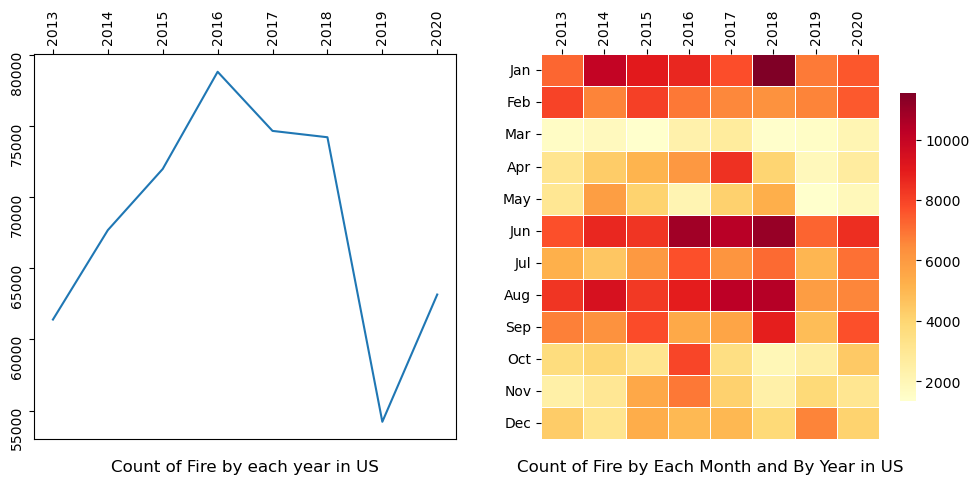

In [150]:
# Significance of the fire : visuvalize the fire occurance by each year and month

#Ref: https://www.geeksforgeeks.org/plot-the-size-of-each-group-in-a-groupby-object-in-pandas/  
# https://www.geeksforgeeks.org/pandas-groupby-unstack/

# Define figure shape
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

# Create xais and y axis input data for the plot
wild_fire_by_month_year = us_wild_fire_df.groupby(['FIRE_START_MONTH', 'FIRE_YEAR']).size().unstack() # ax2 x-axis input data
yaxis_labelvalue = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # y-axis input


ax1.set_title('Count of Fire by each year in US', y=0, pad=-25, verticalalignment="bottom")
# state_plot = sns.heatmap(wild_fire_by_month_state, ax=ax1, cmap='YlOrRd',linewidths=.5, linecolor='white',square=True,cbar_kws={"shrink": 0.4})
state_plot = us_wild_fire_df.groupby(['FIRE_YEAR']).size().plot(kind='line',ax=ax1)
ax1.xaxis.tick_top()
state_plot.tick_params(labelrotation=90)
state_plot.set(xlabel='')
state_plot.set(ylabel='')
# save the plot
plt.savefig('Images/Countof_FireEvents_ByMonth_and_state.png', format='png', dpi=200)

ax2.set_title('Count of Fire by Each Month and By Year in US', y=0, pad=-25, verticalalignment="bottom")
year_plot = sns.heatmap(wild_fire_by_month_year, ax=ax2, cmap='YlOrRd',linewidths=.5, linecolor='white',square=False,cbar_kws={"shrink": 0.8})
ax2.xaxis.tick_top()
year_plot.tick_params(labelrotation=90)
year_plot.set_yticklabels(yaxis_labelvalue, rotation=0)
year_plot.set(xlabel='')
year_plot.set(ylabel='')
# save the plot
plt.savefig('Images/Countof_FireEvents_ByMonth_and_Year.png', format='png', dpi=200)

# display the plot
plt.show()


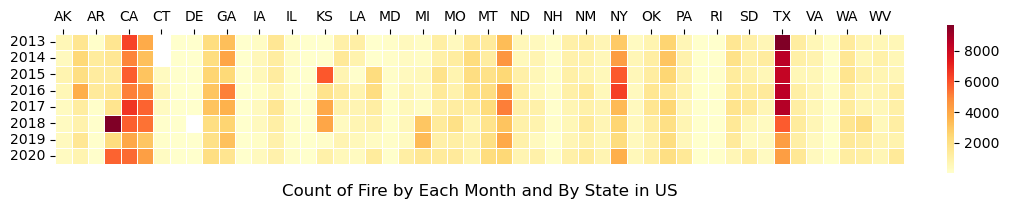

In [156]:
# Significance of the fire : visuvalize the fire occurance by each state and month

# Define figure
fig, (ax1) = plt.subplots(1 ,figsize=(10,10),constrained_layout=True )

# Create xais and y axis input data for the plot
wild_fire_by_month_state = us_wild_fire_df.groupby(['FIRE_YEAR', 'STATE']).size().unstack() # ax1 x-axis input data

# plot the result
ax1.set_title('Count of Fire by Each Month and By State in US', y=0, pad=-25, verticalalignment="bottom")
sns.heatmap(wild_fire_by_month_state, ax=ax1, cmap='YlOrRd',linewidths=.5, linecolor='white',square=True,cbar_kws={"shrink": 0.15})
ax1.xaxis.tick_top()
ax1.tick_params(labelrotation=0)
ax1.set(xlabel='') 
ax1.set(ylabel='')
# save the plot
plt.savefig('Images/Countof_FireEvents_ByMonth_and_state.png', format='png', dpi=200)

# display the plot
plt.show()

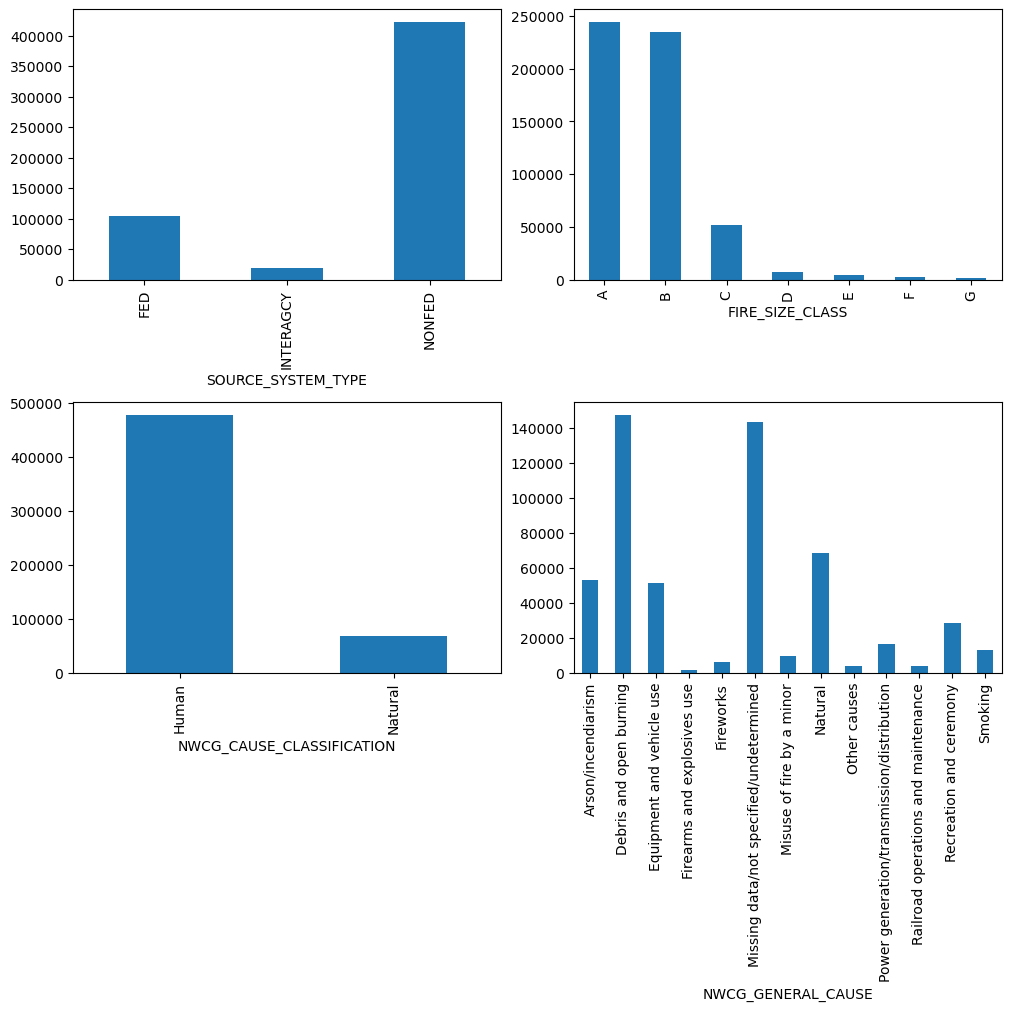

In [146]:
# view of wildfire by classification and cause
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),constrained_layout=True)    
us_wild_fire_df.groupby(['SOURCE_SYSTEM_TYPE']).size().plot(kind='bar',ax=axes[0,0] )
us_wild_fire_df.groupby(['FIRE_SIZE_CLASS']).size().plot(kind='bar',ax=axes[0,1])
us_wild_fire_df.groupby(['NWCG_CAUSE_CLASSIFICATION']).size().plot(kind='bar',ax=axes[1,0])
us_wild_fire_df.groupby(['NWCG_GENERAL_CAUSE']).size().plot(kind='bar',ax=axes[1,1] )
plt.savefig('Images/view_of_wildfire_by_classification_cause.png', format='png', dpi=200)
plt.show()

## Analyzing Climate trend for the years 2013 to 2020

### Preparing the data

In [3]:
# Ensure below prerequisite is met
    # Using the reusable data_merger.ipynb(juypter sourcefile) 
    # merge both climate data from NOAA and wild fire sqlite data from kaggle
    # for the years 2013 to 2020 and create the "climate_wildfire.sqlite". 
    # place the "climate_wildfire.sqlite" file under Resources folder
# ---------------------------------------------------------------#
# read the file path
input_filename = "Resources/climate_wildfire.sqlite"

#create a sql connection to the sqlite
conn = sqlite3.connect(input_filename)

#crete a query string to extract the data from sqlite
query = '''
    SELECT * FROM climate_fire;
'''

# run the query and stored the data int to a dataframe
df_climate_fires_source = pd.read_sql_query(query, conn)

# display the dataframe info
df_climate_fires_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955138 entries, 0 to 955137
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FIRE_NAME             955138 non-null  object 
 1   STATE                 955138 non-null  object 
 2   FIPS_CODE             900319 non-null  object 
 3   FIRE_LATITUDE         955138 non-null  object 
 4   FIRE_LONGITUDE        955138 non-null  object 
 5   FIRE_DATE             955138 non-null  object 
 6   CONTAIN_DATE          819050 non-null  object 
 7   CLOSEST_STATION       955138 non-null  object 
 8   STATION_STATE         955138 non-null  object 
 9   STATION_LAT           955138 non-null  float64
 10  STATION_LON           955138 non-null  float64
 11  READINGS_DATE         955138 non-null  object 
 12  CAUSE_CLASSIFICATION  955138 non-null  object 
 13  FIRE_SIZE             955138 non-null  object 
 14  FIRE_SIZE_CLASS       955138 non-null  object 
 15  

In [4]:
# clearning up the dataframe. removing unwanted columns
df_climate_fires_source.drop(["DAYS_TO_CONTAIN","CAUSE_CLASSIFICATION","FIRE_SIZE_CLASS","FIRE_SIZE",
                "DAYS_TO_CONTAIN","FIRE_NAME","CLOSEST_STATION","STATE","CONTAIN_DATE",
                "FIRE_DATE","FIPS_CODE","FIRE_LATITUDE","FIRE_LONGITUDE","STATION_STATE"], axis=1, inplace=True) 
# Add year column               #
df_climate_fires_source['Year'] = pd.to_datetime(df_climate_fires_source['READINGS_DATE'], format='%m/%d/%Y').dt.strftime('%Y')
df_climate_fires_source

STATION_LAT  STATION_LON READINGS_DATE  ELEVATION  TAVG  TMAX  TMIN  \
0          61.16916   -150.02771      6/1/2020       38.0   118   161    67   
1          64.80309   -147.87606     7/10/2020      131.1   153   211   117   
2          64.80309   -147.87606     6/18/2020      131.1   197   250   139   
3          64.80309   -147.87606     6/22/2020      131.1   114   117   106   
4          64.80309   -147.87606     6/17/2020      131.1   190   244   117   
...             ...          ...           ...        ...   ...   ...   ...   
955133     42.23113    -83.33121    12/31/2013      191.9   -76   -49   -93   
955134     45.07160    -83.56451    12/31/2013      208.3  -122   -99  -177   
955135     42.88210    -85.52297    12/31/2013      240.3   -89   -77   -99   
955136     42.39834    -90.70913    12/31/2013      316.9  -179  -143  -238   
955137     42.55437    -92.40131    12/31/2013      264.2  -196  -143  -282   

        PRCP  SNOW  SNWD  AWND  FIRE_?  Year  
0          0     0     0    47       1  2020  
1          5     0     0    34       1  2020  
2         18     0     0    19       1  2020  
3          8     0     0    30       1  2020  
4          0     0     0    20       1  2020  
...      ...   ...   ...   ...     ...   ...  
955133    20    38    30    56       0  2013  
955134     3     5   230    32       0  2013  
955135    28    74   100    47       0  2013  
955136    30    61   180    28       0  2013  
955137    18    33   100    28       0  2013  

[955138 rows x 13 columns]

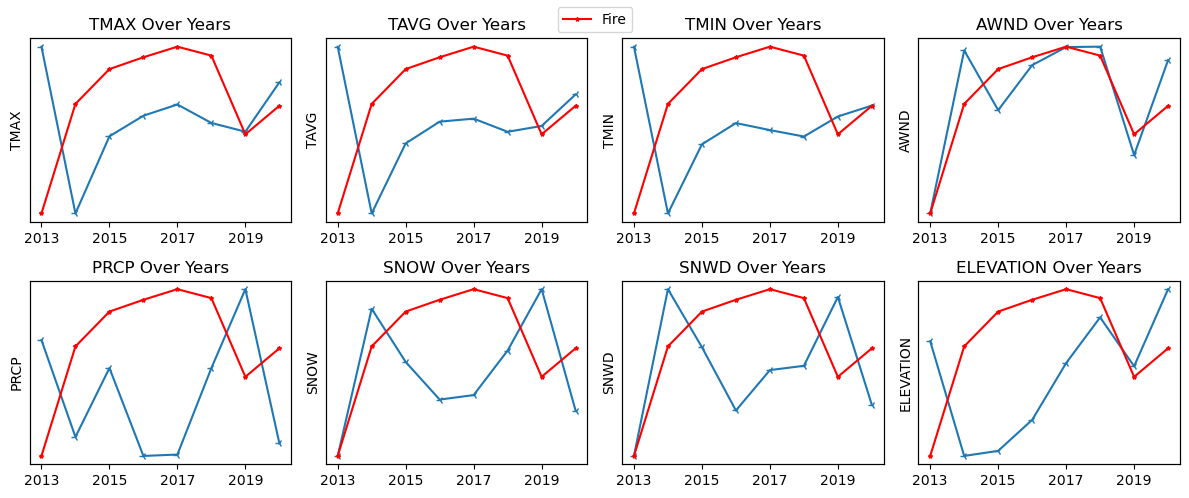

In [41]:
# List of climate factors for analysis
climate_factors = ['TMAX','TAVG','TMIN','AWND','PRCP',"SNOW","SNWD",'ELEVATION']

# Calculate the count of fires per year
count_of_fire_by_year = df_climate_fires_source.groupby(df_climate_fires_source['Year'])['FIRE_?'].count() 

# Create a figure and subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()  # Flatten the array of axes

# Loop through each climate factor and create subplots
for i, column in enumerate(climate_factors):
    ax = axes[i]

    # group the climate factor by year and calculate the mean of the current climate factor column
    climate_data = df_climate_fires_source.groupby(df_climate_fires_source['Year'])[column].mean()  # Change 'mean()' to desired aggregation

    # Plot the climate data
    ax.plot(climate_data.index, climate_data.values, marker='3',label='climate')
    ax.set_title(f'{column} Over Years')
    ax.set_xlabel('')
    ax.set_ylabel(column)
    ax.set_xticks(np.arange(0, len(count_of_fire_by_year)+1, 2))
    ax.set_yticks([])

    # Create a plot to show fire trend over the year with this climate factor
    ax2 = ax.twinx()
    # Plot the fire data
    ax2.plot(count_of_fire_by_year.index, count_of_fire_by_year.values, marker='*' , markersize=3, color='red', label='Fire')
    ax2.set_yticks([])
    ax2.set_ylabel('')

handles, ax2_label = ax2.get_legend_handles_labels()
fig.legend(handles, ax2_label, loc='upper center')

plt.tight_layout()
plt.show()

## ML Data Model Implementation and Analysis

### Predicting the fire occurance using Random forest
##### Which climate feature contributed to fire occurances

In [13]:
# Create a copy of dataframe for ML analysis
df_climate_fires = df_climate_fires_source.copy()
# remove unwanted columns
df_climate_fires = df_climate_fires.drop(['Year','READINGS_DATE'], axis=1, inplace=True) 

# display the dataframe
df_climate_fires

# Define features set
X = df_climate_fires.copy()
X.drop(["FIRE_?"], axis=1, inplace=True) 

# Define target vector
y = df_climate_fires["FIRE_?"].ravel()
y[:5]

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

   STATION_LAT  STATION_LON  ELEVATION  TAVG  TMAX  TMIN  PRCP  SNOW  SNWD  \
0     61.16916   -150.02771       38.0   118   161    67     0     0     0   
1     64.80309   -147.87606      131.1   153   211   117     5     0     0   
2     64.80309   -147.87606      131.1   197   250   139    18     0     0   
3     64.80309   -147.87606      131.1   114   117   106     8     0     0   
4     64.80309   -147.87606      131.1   190   244   117     0     0     0   

   AWND  
0    47  
1    34  
2    19  
3    30  
4    20  
[1 1 1 1 1]
Confusion Matrix


Predicted 0  Predicted 1
Actual 0        79411        13909
Actual 1        10972       134493

Accuracy Score : 0.8958016625834956
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     93320
           1       0.91      0.92      0.92    145465

    accuracy                           0.90    238785
   macro avg       0.89      0.89      0.89    238785
weighted avg       0.90      0.90      0.90    238785



##### Feature Importance

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

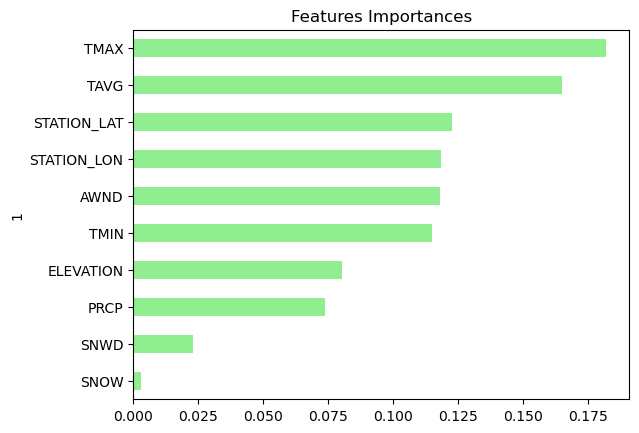

In [14]:
# Random Forests in sklearn will automatically calculate feature importance
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Based on Random state analysis it is observed that the top three key features which contributed to fire occurances are maximium temperature, location and wind.

This model has a accuracy of 90% with precision at around 91% and recall at 92% which could potentially mean there is a possiblity of false positive and false negative could be less than 10%. This could be due to data as each climate factor has various considerations and all factors are is not considered for this analysis.

On overall the model would predicts realiable fire occurance and it performed pretty good.

### Predicting the fire occurance using Neural Network

#### Plot the predicition(train) and observation(test)

In [49]:
# Ref: https://www.tutorialspoint.com/keras/keras_model_compilation.htm
from sklearn.preprocessing import LabelEncoder

# make copy of source dataframe for nneural network analysis and remove readings date
df_climate_fires_nn = df_climate_fires_source.copy()
df_climate_fires_nn.drop(['READINGS_DATE'], axis=1, inplace=True)

# Split our preprocessed data into our features and target arrays
X=df_climate_fires_nn.drop('FIRE_?',axis=1).values
y=df_climate_fires_nn['FIRE_?'].values

# Split the preprocessed data into a training and testing dataset (80% will be used for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=48,stratify=None)

# Create a MinMaxScaler instances
scaler = MinMaxScaler()

# Fit the MinMaxScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features=len(X_train_scaled[0])
print(f'Number of input features : {input_features}')

# Define the model - deep neural net
nn = tf.keras.models.Sequential()

# Add more hidden layers with increased complexity
nn.add(tf.keras.layers.Dense(units=428, input_dim=input_features, activation='relu'))
nn.add(tf.keras.layers.Dense(units=1056, activation='relu'))
nn.add(tf.keras.layers.Dense(units=288, activation='relu'))
nn.add(tf.keras.layers.Dense(units=196, activation='relu'))
nn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
nn.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])  # Use 'binary_crossentropy' for binary classification

# Train the model
model_output = nn.fit(X_train_scaled, y_train, epochs=150, batch_size=128, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = nn.evaluate(X_test_scaled, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Number of input features : 11
Epoch 1/150
4776/4776 [==============================] - 98s 20ms/step - loss: 0.0687 - accuracy: 0.7848 - val_loss: 0.0606 - val_accuracy: 0.8172
Epoch 2/150
4776/4776 [==============================] - 102s 21ms/step - loss: 0.0595 - accuracy: 0.8178 - val_loss: 0.0561 - val_accuracy: 0.8339
Epoch 3/150
4776/4776 [==============================] - 110s 23ms/step - loss: 0.0564 - accuracy: 0.8287 - val_loss: 0.0548 - val_accuracy: 0.8392
Epoch 4/150
4776/4776 [==============================] - 104s 22ms/step - loss: 0.0541 - accuracy: 0.8368 - val_loss: 0.0537 - val_accuracy: 0.8340
Epoch 5/150
4776/4776 [==============================] - 105s 22ms/step - loss: 0.0523 - accuracy: 0.8428 - val_loss: 0.0507 - val_accuracy: 0.8466
Epoch 6/150
4776/4776 [==============================] - 104s 22ms/step - loss: 0.0514 - accuracy: 0.8458 - val_loss: 0.0503 - val_accuracy: 0.8471
Epoch 7/150
4776/4776 [==============================] - 102s 21ms/step - loss: 0.0

In [50]:
# Export our model to HDF5 file
nn.save("models/cf_on_US-wf_pred_5hidden_1ouput_msle_Adam_0.86_accuracy_model3.h5")

C:\Users\Kinde\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


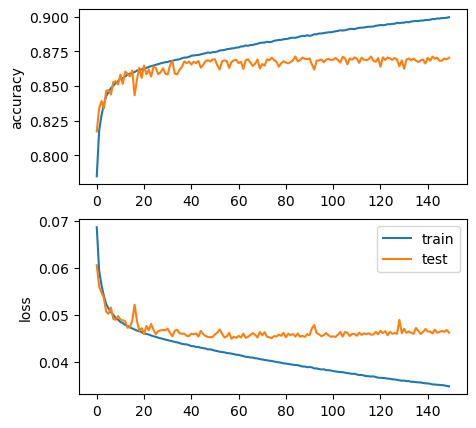

In [51]:
# plotting the model out
fig, ((ax1, ax2)) = plt.subplots(2,figsize=(5, 5))
ax1.plot(model_output.history['accuracy'], label='train')
ax1.plot(model_output.history['val_accuracy'], label='test')
ax1.set(xlabel='', ylabel='accuracy')

ax2.plot(model_output.history['loss'], label='train')
ax2.plot(model_output.history['val_loss'], label='test')
ax2.set(xlabel='', ylabel='loss')

plt.legend()
plt.show()